In [5]:
CONFIG_PATH = "configs/small_sample_sub_minority.yml"
from utils import get_config, join_sets, load_model, print_log, save_model, load_model_dict
config = get_config(CONFIG_PATH, "_curation", print_config = False)
active_user_votes_thres = config["active_user_votes_thres"]
batch_size = config["batch_size"]

GPU ready...
Smart using cuda:3


In [6]:
from collections import Counter, defaultdict
import os
import random
import shutil
import numpy as np
import pandas as pd
from superdebug import debug
import torch
from process_data import get_model_input
from model import get_best_model
from matplotlib import pyplot as plt
from venn import venn, pseudovenn

##### Preprocess

Load model and data

In [7]:
target, original_feature_map, categorical_features, string_features, train_data, test_data, test_data_info, train_submission_upvote_df, num_all_users = get_model_input(config)
extra_input = (categorical_features, string_features, target)
model, token_embedding = get_best_model(config, categorical_features, string_features, original_feature_map)
model.eval()
all_users = list(range(num_all_users + 1))

------------------ 2022-08-06 17:36:18 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/process_data.py:345 get_model_input
Loading prepared data...
------------------ 2022-08-06 17:36:18 ------------------
------------------ 2022-08-06 17:36:21 ------------------
DEBUG: 1 vars: ['original_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:248 get_tokenizer
0 / 3.  original_token_num num val: 30522
------------------ 2022-08-06 17:36:21 ------------------
------------------ 2022-08-06 17:36:21 ------------------
DEBUG: 1 vars: ['latest_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:260 get_tokenizer
0 / 4.  latest_token_num num val: 153833
------------------ 2022-08-06 17:36:21 ------------------


Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


------------------ 2022-08-06 17:36:22 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:110 load_model
Loading best model...
------------------ 2022-08-06 17:36:22 ------------------


Collect submissions and active users in different subreddits

In [8]:
def get_subreddits_submissions(train_data:pd.DataFrame, test_data:pd.DataFrame, user_votes_thres = 0):
    subreddit_votes_counter = Counter()
    subreddit_active_users = defaultdict(Counter)
    subreddit_train_submissions = defaultdict(dict)
    subreddit_test_submissions = defaultdict(dict)
    all_submissions = dict()
    for i, row in train_data.iterrows():
        subreddit_votes_counter[row["SUBREDDIT"]] += 1
        subreddit_active_users[row["SUBREDDIT"]][row["USERNAME"]] += 1
        if row["SUBMISSION_ID"] not in subreddit_train_submissions[row["SUBREDDIT"]]:
            subreddit_train_submissions[row["SUBREDDIT"]][row["SUBMISSION_ID"]] = row
            all_submissions[row["SUBMISSION_ID"]] = row
    for subreddit in subreddit_active_users:
        users_vote_count = subreddit_active_users[subreddit]
        subreddit_active_users[subreddit] = {user for user in users_vote_count if users_vote_count[user] >= user_votes_thres}
    for i, row in test_data.iterrows():
        if row["SUBMISSION_ID"] not in subreddit_test_submissions[row["SUBREDDIT"]]:
            subreddit_test_submissions[row["SUBREDDIT"]][row["SUBMISSION_ID"]] = row
            all_submissions[row["SUBMISSION_ID"]] = row
    return subreddit_votes_counter, subreddit_active_users, subreddit_train_submissions, subreddit_test_submissions, all_submissions

subreddit_votes_counter, subreddit_active_users, subreddit_train_submissions, subreddit_test_submissions, all_submissions = get_subreddits_submissions(train_data, test_data, user_votes_thres = active_user_votes_thres) # subreddit_votes_counter, subreddit_users, subreddit_train_submissions are based on train_data, subreddit_test_submissions are based on test_data

Record down existing votes

So that we can use them to substitute the predicted votes

In [9]:
def record_existing_votes(train_data:pd.DataFrame):
    # collect existing votes
    existing_votes = {}
    existing_user_updown_votes = defaultdict(Counter)
    existing_user_votes = Counter()
    existing_submission_votes = defaultdict(Counter)
    usernames = train_data["USERNAME"].to_list()
    sub_ids = train_data["SUBMISSION_ID"].to_list()
    votes = train_data["VOTE"].to_list()
    for row_i in range(len(train_data)):
        existing_votes[f'{usernames[row_i]}-{sub_ids[row_i]}'] = votes[row_i]
        existing_user_updown_votes[usernames[row_i]][votes[row_i]] += 1
        existing_user_votes[usernames[row_i]] += 1
        existing_submission_votes[sub_ids[row_i]][votes[row_i]] += 1
    return existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes
existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes = record_existing_votes(train_data)


#### Predict votes for all the users on all submissions

Define required functions

In [65]:
from typing import Union
# from tqdm import tqdm
from tqdm.notebook import tqdm
from train import evaluate_model
from model import get_tokenizer

def convert_group_users_subreddit_submissions_data(group_users:Union[set,list], unique_submissions:dict):
    group_users_submissions_data = []
    if type(unique_submissions) == dict:
        unique_submissions = pd.DataFrame(list(unique_submissions.values()))

    for user in tqdm(group_users):
        # for submission_id in unique_submissions:
        #     submission:pd.DataFrame = unique_submissions[submission_id].copy(deep=True)
        #     submission["USERNAME"] = user
        #     group_users_submissions_data.append(submission)
        submissions = unique_submissions.copy(deep=True)
        submissions["USERNAME"] = [user] * len(submissions)
        group_users_submissions_data.append(submissions)

    group_users_submissions_data = pd.concat(group_users_submissions_data,axis=0)
    return group_users_submissions_data
def predict_group_users_submissions_votes(model, group_users_submissions_data, batch_size):
    # predict unseen votes
    return evaluate_model(config, model, data=group_users_submissions_data, weights = None, batch_size=config["batch_size"], sample_voted_users=False, extra_input = extra_input, ret = "prediction") # ndarray size: (3423664, 1)
pred_all_user_submission_vote_score_matrix = None

# model.device = "cuda:0"
def get_group_user_submission_vote_score_matrix(predicted_group_users_submissions_votes:np.ndarray, group_users, group_users_submissions_data:pd.DataFrame, existing_votes, existing_pred_user_submission_vote_score_matrix = None):
    if existing_pred_user_submission_vote_score_matrix is not None:
        pred_user_submission_vote_score_matrix = existing_pred_user_submission_vote_score_matrix
    else:
        all_sub_ids = group_users_submissions_data["SUBMISSION_ID"].unique()
        pred_user_submission_vote_score_matrix = pd.DataFrame(- np.ones([max(group_users) + 1, len(all_sub_ids)], dtype = float), columns=all_sub_ids)
    pred_user_submission_vote_matrix = pd.DataFrame(- np.ones([max(group_users) + 1, len(all_sub_ids)], dtype = int), columns=all_sub_ids) # use ground truth vote if available, -1 for not in data
    each_submission_votes = {}
    each_user_confidence = defaultdict(list)
    submission_ids = group_users_submissions_data["SUBMISSION_ID"].to_numpy()
    usernames = group_users_submissions_data["USERNAME"].to_numpy()
    for row_i in tqdm(range(len(group_users_submissions_data))):
        submission_id = submission_ids[row_i]
        username = usernames[row_i]
        if existing_pred_user_submission_vote_score_matrix is not None:
            vote_score = existing_pred_user_submission_vote_score_matrix[username, submission_id]
        else:
            vote_score = predicted_group_users_submissions_votes[row_i, 0]
            pred_user_submission_vote_score_matrix[username, submission_id] = vote_score
        if f'{username}-{submission_id}' not in existing_votes:
            vote = int(vote_score >= 0.5)
        else: # use existing votes if available
            vote = int(existing_votes[f'{username}-{submission_id}'] >= 0.5)
            
        if submission_id not in each_submission_votes:
            each_submission_votes[submission_id] = [0, 0]
        each_user_confidence[username].append(abs(vote_score - 0.5))
        pred_user_submission_vote_matrix.at[username, submission_id] = vote
        each_submission_votes[submission_id][vote] += 1
    assert (pred_user_submission_vote_matrix.to_numpy() != -1).sum() > 0
    
    # analyze user confidence
    for username in each_user_confidence:
        each_user_confidence[username] = float(np.mean(each_user_confidence[username]))
        
    # calculate %upvotes for each submission
    for submission_id in each_submission_votes:
        each_submission_votes[submission_id].append(each_submission_votes[submission_id][1] / (each_submission_votes[submission_id][0] + each_submission_votes[submission_id][1])) # %upvotes
    return each_submission_votes, each_user_confidence, pred_user_submission_vote_score_matrix, pred_user_submission_vote_matrix
def get_group_users_preferred_submissions(each_submission_votes:dict, thres = 0.9):
    # include submissions to preferred_submissions where %upvotes is higher than threshold
    group_preferred_submissions = set()
    for submission_id in each_submission_votes:
        if each_submission_votes[submission_id][-1] >= thres:
            group_preferred_submissions.add(submission_id)

    # sort submissions using %upvotes
    group_submissions_ranking = list(each_submission_votes.keys())
    group_submissions_ranking.sort(reverse=True, key=lambda id: each_submission_votes[id][-1])
    return group_preferred_submissions, group_submissions_ranking

Convert data to model input, then run model to make predictions, and obtain prediction score matrix and vote matrix. Note that we use actual votes to replace predicted votes when available.

_!!! This process can be time consuming & need more than 200G memory for medium sized dataset, and is not necessary if we use user_embedding to cluster active users_

In [11]:
if config["user_grouping_method"] == "predict_all_submissions":
    # Convert data to model input
    # TODO: not all users
    all_users_submissions_data = convert_group_users_subreddit_submissions_data(all_users, all_submissions)

    # run model to make predictions
    model.to(model.device)
    predicted_all_users_submissions_votes = predict_group_users_submissions_votes(model, all_users_submissions_data, batch_size)
    debug(predicted_all_users_submissions_votes=predicted_all_users_submissions_votes)

    import pickle
    pickle.dump(predicted_all_users_submissions_votes, open("output/predicted_all_users_submissions_votes.pt", "wb"))
    # predicted_all_users_submissions_votes = pickle.load(open("output/predicted_all_users_submissions_votes.pt", "rb"))

    # Obtain prediction score matrix and vote matrix. We use actual votes to replace predicted votes when available
    all_submission_votes, all_users_confidence, pred_all_user_submission_vote_score_matrix, pred_all_user_submission_vote_matrix = get_group_user_submission_vote_score_matrix(predicted_all_users_submissions_votes, all_users, all_users_submissions_data, existing_votes)
    
    # all_users_preferred_submissions, all_preferred_submissions_ranking = get_group_users_preferred_submissions(all_submission_votes, thres = config["upvote_downvote_ratio_thres"])

Calculate Pearson correlation between users

In [12]:
if config["user_grouping_method"] == "predict_all_submissions":
    debug((pred_all_user_submission_vote_matrix==-1).any())
    debug(pred_all_user_submission_vote_score_matrix=pred_all_user_submission_vote_score_matrix, pred_all_user_submission_vote_matrix=pred_all_user_submission_vote_matrix)
    vote_score_pearson_corr = np.corrcoef(pred_all_user_submission_vote_score_matrix) # (697, 697)
    debug(vote_score_pearson_corr=vote_score_pearson_corr)

#### Perform curation on a subreddit

Select a subreddit from the most popular subreddits

In [13]:
common_subreddits_counts = subreddit_votes_counter.most_common(20)
prompt = []
for subreddit_id, vote_counts in common_subreddits_counts:
    subreddit_name_str = (original_feature_map['SUBREDDIT'][subreddit_id] + ', ') if 'SUBREDDIT' in original_feature_map else ''
    prompt.append(f"Subreddit {subreddit_id}: {subreddit_name_str}{vote_counts} votes")
prompt = "\n".join(prompt)
a_subreddit = input(f"{prompt}\nSelect a subreddit: ")
if 'SUBREDDIT' in original_feature_map:
    a_subreddit = int(a_subreddit)
    subreddit_name_str = (f" ({original_feature_map['SUBREDDIT'][a_subreddit]})")
else:
    subreddit_name_str =  ''
print_log(config["log_path"], f"Selected subreddit: {a_subreddit}{subreddit_name_str}")
a_subreddit_active_users:set = subreddit_active_users[a_subreddit]
print_log(config["log_path"], f"In train data, subreddit {a_subreddit} have {len(a_subreddit_active_users)} active users (who votes >= {active_user_votes_thres} times), {subreddit_votes_counter[a_subreddit]} votes and {len(subreddit_train_submissions[a_subreddit])} unique submissions. In test data, subreddit {a_subreddit} have {len(subreddit_test_submissions[a_subreddit])} unique submissions.") 

------------------ 2022-08-06 17:37:11 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Selected subreddit: r/funny
------------------ 2022-08-06 17:37:11 ------------------
------------------ 2022-08-06 17:37:11 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
In train data, subreddit r/funny have 47 active users (who votes >= 5 times), 4722 votes and 1539 unique submissions. In test data, subreddit r/funny have 604 unique submissions.
------------------ 2022-08-06 17:37:11 ------------------


In [14]:
user_grouping_method = config["user_grouping_method"]
user_grouping_method = "all_user_as_group" # TODO: change this
manual_user_groups = config["manual_user_groups"]
# manual_user_groups = {"Conservative": {66, 39, 10, 44, 16, 60}, "Democratic":{0, 65, 64, 37, 49, 52, 20, 22, 23, 26, 29}}
debug(user_grouping_method=user_grouping_method)


------------------ 2022-08-06 17:37:11 ------------------
DEBUG: 1 vars: ['user_grouping_method'], at <ipython-input-14-fc6129a353f9>:5 <module>
0 / 5.  user_grouping_method str len 5: votes
------------------ 2022-08-06 17:37:11 ------------------


In [19]:
import sklearn.decomposition

def get_bool_vec(selected_ids, vec_size):
    bool_vec = torch.zeros([vec_size], dtype = bool)
    for user in selected_ids:
        bool_vec[user] = True
    return bool_vec

def get_user_reps(selected_users, all_user_embedding, train_data:pd.DataFrame = None, selected_submissions = None, method = "neural"):
    assert all_user_embedding is not None
    selected_users_bool_vec = get_bool_vec(selected_users, all_user_embedding.shape[0])
    # user_user_i_map = {}
    selected_user_i_user_map = {}
    user_i = 0
    for user, in_subreddit in enumerate(selected_users_bool_vec):
        if in_subreddit:
            # user_user_i_map[user] = user_i
            selected_user_i_user_map[user_i] = user
            user_i += 1
    # assert len(user_user_i_map) == len(user_i_user_map)
    selected_users_reps = None
    if method == "neural":
        selected_users_reps = all_user_embedding[selected_users_bool_vec, :]
    elif method == "votes":
        assert train_data is not None and selected_submissions is not None
        sub_sub_i_map = {sub: sub_i for sub_i, sub in enumerate(list(selected_submissions.keys()))}
        users_reps = torch.zeros([all_user_embedding.shape[0], len(selected_submissions)])
        for row_i, row in train_data.iterrows():
            if row["USERNAME"] in selected_users and row["SUBMISSION_ID"] in selected_submissions:
                vote = 1 if row["VOTE"] == 1 else -1
                users_reps[row["USERNAME"], sub_sub_i_map[row["SUBMISSION_ID"]]] = vote
        selected_users_reps = users_reps[selected_users_bool_vec, :]
        users_vote_sum = (selected_users_reps * selected_users_reps).sum(axis = -1, keepdim= True)
        assert (users_vote_sum != 0).all()
        # selected_users_reps = selected_users_reps / users_vote_sum # average votes on each submission
        debug(selected_users_reps_before_PCA=selected_users_reps.shape)
        pca_solver = sklearn.decomposition.PCA(n_components=0.95)
        selected_users_reps = pca_solver.fit_transform(selected_users_reps)
        debug(selected_users_reps_after_PCA = selected_users_reps.shape)

    return selected_users_reps, selected_user_i_user_map


##### Obtain representations for active users

User representation will be used to cluster users into groups if `user_grouping_method` is "`neural`" or "`vote`"

Either use this one... (clustering using vote prediction score on submissions in this subreddit, make sure `pred_all_user_submission_vote_score_matrix` is available)

In [20]:
if pred_all_user_submission_vote_score_matrix is not None:
    debug(pred_all_user_submission_vote_score_matrix=pred_all_user_submission_vote_score_matrix)
    subreddit_submissions_bool_vec = get_bool_vec(subreddit_test_submissions[a_subreddit].keys(), pred_all_user_submission_vote_score_matrix.shape[1])
    a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map = get_user_reps(a_subreddit_active_users, all_user_embedding=pred_all_user_submission_vote_score_matrix[:, subreddit_submissions_bool_vec], train_data=train_data, selected_submissions = subreddit_train_submissions[a_subreddit], method = user_grouping_method)

Or this one... (cluster using user_embedding or sparse actual votes)

In [21]:
if pred_all_user_submission_vote_score_matrix is None:
    all_username_tokens = [f"USERNAME_{user_i}" for user_i in all_users]
    all_username_token_ids = torch.tensor(model.tokenizer.convert_tokens_to_ids(all_username_tokens))
    all_username_token_ids = all_username_token_ids.to(model.device); model = model.to(model.device)
    with torch.no_grad():
        user_embedding = model.lm_encoder.embeddings.word_embeddings(all_username_token_ids)
    # debug(all_username_tokens=all_username_tokens, all_username_token_ids=all_username_token_ids, user_embedding=user_embedding)
    a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map = get_user_reps(a_subreddit_active_users, all_user_embedding=user_embedding, train_data=train_data, selected_submissions = subreddit_train_submissions[a_subreddit], method = user_grouping_method)

------------------ 2022-08-06 17:40:01 ------------------
DEBUG: 1 vars: ['selected_users_reps'], at <ipython-input-19-1bddb074466e>:36 get_user_reps
0 / 7.  selected_users_reps Tensor size: torch.Size([47, 1539]) val: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
------------------ 2022-08-06 17:40:01 ------------------
------------------ 2022-08-06 17:40:01 ------------------
DEBUG: 1 vars: ['selected_users_reps'], at <ipython-input-19-1bddb074466e>:39 get_user_reps
0 / 8.  selected_users_reps ndarray size: (47, 41) val: [[-0.25890883 -0.11345328  0.5527872  ... -0.17322755 -0.26432184
  -0.59624279]
 [-0.22600384 -0.2881086  -0.15077428 ... -0.06213044 -0.07388871
   0.24266361]
 [-0.19233876 -0.06853775 -0.01138292 ... -0.01035731 -0.02543764
   0.05338689]
 ...
 [-0.2615407   

##### Cluster active users into multiple groups

In [22]:
def get_user_groups(selected_users_reps, selected_user_i_user_map:dict, user_grouping_method = "neural", existing_user_votes=None, manual_user_groups=None):
    group_centers = None
    if user_grouping_method == "single_user_as_group":
        assert existing_user_votes is not None
        users_in_groups = list(selected_user_i_user_map.values())
        users_in_groups.sort(key=lambda x:existing_user_votes[x])
        users_in_groups = users_in_groups[:10] + users_in_groups[-10:]
        users_in_groups = {i: {user} for i,user in enumerate(users_in_groups)}
        # users_in_groups = {i: {user} for i,user in selected_user_i_user_map.items()}
    elif user_grouping_method == "all_user_as_group":
        pass # TODO
    elif user_grouping_method == "manual":
        users_in_groups = manual_user_groups
    else: # "neural" or "votes"
        n_groups = int(len(selected_user_i_user_map) / 5) # TODO: change how many users in a group
        debug(num_selected_users = len(selected_user_i_user_map), n_groups=n_groups) # n_groups: 118
        debug("Begin grouping...")
        from sklearn.cluster import KMeans
        grouping = KMeans(n_clusters = n_groups, random_state = 42, verbose = 0).fit(selected_users_reps)
        group_centers = grouping.cluster_centers_
        """
        from sklearn.cluster import AgglomerativeClustering
        grouping = AgglomerativeClustering(linkage = "complete").fit(selected_users_reps)
        """
        """
        from sklearn.cluster import SpectralClustering
        grouping = SpectralClustering(n_groups, random_state = 42, verbose = 0).fit(selected_users_reps)
        """
        labels = grouping.labels_ # grouping.labels_: [584 350 948 ... 813 938 152]
        """
        from sklearn.mixture import GaussianMixture
        labels = GaussianMixture(n_groups, random_state = 42, verbose = 0).fit_predict(selected_users_reps)
        """
        users_in_groups = defaultdict(set)
        usernames_in_groups = defaultdict(set)
        for user_i, group_x in enumerate(labels): 
            users_in_groups[group_x].add(selected_user_i_user_map[user_i])
            usernames_in_groups[group_x].add(original_feature_map["USERNAME"][selected_user_i_user_map[user_i]])
        assert len(join_sets(users_in_groups.values())) == sum([len(users) for users in users_in_groups.values()])
        debug(group_user_num=str({group_x: len(users_in_groups[group_x]) for group_x in users_in_groups}))
        debug(usernames_in_groups=str(usernames_in_groups))
    return users_in_groups, group_centers
if type(a_subreddit_active_users_reps) == torch.tensor: a_subreddit_active_users_reps = a_subreddit_active_users_reps.cpu()
users_in_groups, group_centers = get_user_groups(a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map, user_grouping_method=user_grouping_method, existing_user_votes=existing_user_votes, manual_user_groups=manual_user_groups)

------------------ 2022-08-06 17:40:01 ------------------
DEBUG: 2 vars: ['num_selected_users', 'n_groups'], at <ipython-input-22-13289430cc92>:14 get_user_groups
0 / 10.  num_selected_users num val: 47
1 / 11.  n_groups num val: 9
------------------ 2022-08-06 17:40:01 ------------------
------------------ 2022-08-06 17:40:01 ------------------
DEBUG: at <ipython-input-22-13289430cc92>:15 get_user_groups
Begin grouping...
------------------ 2022-08-06 17:40:01 ------------------
------------------ 2022-08-06 17:40:01 ------------------
DEBUG: 1 vars: ['group_user_num'], at <ipython-input-22-13289430cc92>:38 get_user_groups
0 / 12.  group_user_num str len 55: {1: 28, 3: 1, 7: 1, 8: 8, 4: 1, 0: 1, 5: 5, 6: 1, 2: 1}
------------------ 2022-08-06 17:40:01 ------------------
------------------ 2022-08-06 17:40:01 ------------------
DEBUG: 1 vars: ['usernames_in_groups'], at <ipython-input-22-13289430cc92>:39 get_user_groups
0 / 13.  usernames_in_groups str len 736: defaultdict(<class 'set'

##### Predict preferred submissions of each group

Print original submissions

In [ ]:
def get_submissions_text(submission_ids):
    submissions_text = []
    for submission_id in submission_ids:
        if "SUBMISSION_ID" in original_feature_map:
            submission_id = original_feature_map["SUBMISSION_ID"][submission_id]
        submissions_text.append(submission_text_map[submission_id])
    return submissions_text

print(get_submissions_text(subreddit_test_submissions[a_subreddit]))

Preparation

In [63]:
submission_text_map = test_data[["SUBMISSION_ID", "SUBMISSION_TEXT"]].drop_duplicates("SUBMISSION_ID").set_index("SUBMISSION_ID").to_dict()['SUBMISSION_TEXT']
pred_group_votes_info = {}

Set parameters

In [58]:
batch_size = 1024
# thres = config["upvote_downvote_ratio_thres"]
thres = 0.9 # TODO:

Predict and show their relationship using venn.

------------------ 2022-08-06 21:21:56 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Predicting group 1 with users {26240, 7811, 27395, 31107, 14601, 7563, 15381, 17190, 8617, 8757, 25272, 26812, 30407, 2507, 7509, 23254, 2904, 20313, 1501, 21985, 6629, 9067, 18539, 21103, 2676, 23669, 27384, 13436}
------------------ 2022-08-06 21:21:56 ------------------
------------------ 2022-08-06 21:21:56 ------------------
DEBUG: 1 vars: ['?'], at <ipython-input-70-5994bfe643da>:43 predict_groups_preferences
0 / 6704.  ? ndarray size: (28, 604) val: [[0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 1 1 ... 0 1 0]
 [0 0 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]]
------------------ 2022-08-06 21:21:56 ------------------
------------------ 2022-08-06 21:21:56 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 1 prefers 54/604 submissions (sorted using %upvotes): ['t3

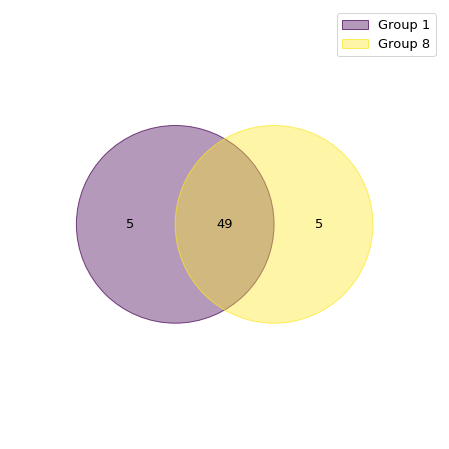

------------------ 2022-08-06 21:21:56 ------------------
DEBUG: at <ipython-input-70-5994bfe643da>:69 predict_groups_preferences
Figure saved in output/figures/preferred_subs/2_groups.png
------------------ 2022-08-06 21:21:56 ------------------
------------------ 2022-08-06 21:21:56 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Predicting group 5 with users {27461, 25042, 15029, 21211, 27548}
------------------ 2022-08-06 21:21:56 ------------------
------------------ 2022-08-06 21:21:56 ------------------
DEBUG: 1 vars: ['?'], at <ipython-input-70-5994bfe643da>:43 predict_groups_preferences
0 / 6706.  ? ndarray size: (5, 604) val: [[0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 1 0]]
------------------ 2022-08-06 21:21:56 ------------------
------------------ 2022-08-06 21:21:56 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
U

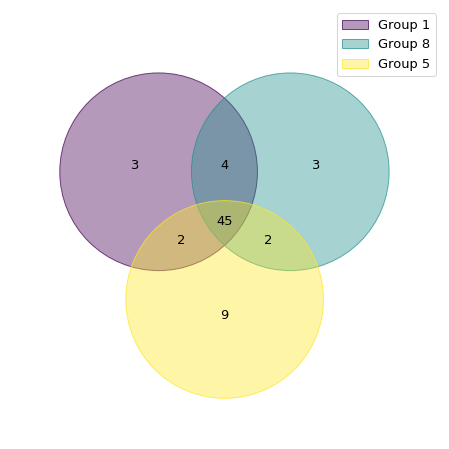

------------------ 2022-08-06 21:21:56 ------------------
DEBUG: at <ipython-input-70-5994bfe643da>:69 predict_groups_preferences
Figure saved in output/figures/preferred_subs/3_groups.png
------------------ 2022-08-06 21:21:56 ------------------


In [70]:

def predict_groups_preferences(users_in_groups, unique_submissions:dict, thres = 0.5, group_centers=None, user_grouping_method = "rep", existing_votes = None, existing_user_updown_votes = None, pred_group_votes_info = None):
    # users_in_groups = existing_user_votes.most_common(3)
    groups_preferred_submissions = {}
    groups_preferred_submissions_text = {}
    groups_submission_upvote_count_matrix = np.zeros([len(users_in_groups), len(unique_submissions)])
    unique_submissions_ids = list(unique_submissions.keys())
    used_group_centers = []
    if os.path.exists(config["preferred_submissions_venn_figure_dir"]):
        shutil.rmtree(config["preferred_submissions_venn_figure_dir"])
    os.makedirs(config["preferred_submissions_venn_figure_dir"], exist_ok=True)
    for group_x in users_in_groups:
        if (user_grouping_method != "single_user_as_group") and (len(users_in_groups[group_x]) <= config["group_user_num_lower_thres"] or len(users_in_groups[group_x]) > config["group_user_num_upper_thres"]): # keep middle sized centers
            continue
        if group_centers is not None: # only keep not similar centers
            group_x_center = group_centers[group_x]
            similar_center = False
            for center in used_group_centers:
                if np.dot(group_x_center, center) > 0:
                    similar_center = True
                    break
            if similar_center:
                # continue
                print_log(config["log_path"], "Have similar center with existing group")
            used_group_centers.append(group_x_center)

        ################ predicting votes of some users and some submissions ##################
        print_log(config["log_path"], f"Predicting group {group_x} with users {users_in_groups[group_x]}")
        
        if group_x not in pred_group_votes_info:
            group_x_subreddit_submissions_data = convert_group_users_subreddit_submissions_data(users_in_groups[group_x], unique_submissions)
            predicted_group_x_submissions_votes = predict_group_users_submissions_votes(model, group_x_subreddit_submissions_data, batch_size)
            group_x_submission_votes, group_x_confidence, pred_group_x_subreddit_submission_vote_score_matrix, pred_group_x_subreddit_submission_vote_matrix = get_group_user_submission_vote_score_matrix(predicted_group_x_submissions_votes, users_in_groups[group_x], group_x_subreddit_submissions_data, existing_votes)
            
            pred_group_votes_info[group_x] = group_x_submission_votes, group_x_confidence, pred_group_x_subreddit_submission_vote_score_matrix, pred_group_x_subreddit_submission_vote_matrix
        else:
            group_x_submission_votes, group_x_confidence, pred_group_x_subreddit_submission_vote_score_matrix, pred_group_x_subreddit_submission_vote_matrix = pred_group_votes_info[group_x]
        
        
        group_x_preferred_submissions, group_x_preferred_submissions_ranking = get_group_users_preferred_submissions(group_x_submission_votes, thres = thres)
    
        pred_group_x_subreddit_submission_vote_matrix_np = pred_group_x_subreddit_submission_vote_matrix[unique_submissions_ids].to_numpy()
        pred_group_x_subreddit_submission_vote_matrix_np = pred_group_x_subreddit_submission_vote_matrix_np[pred_group_x_subreddit_submission_vote_matrix_np.sum(axis=1) >= 0]
        debug(pred_group_x_subreddit_submission_vote_matrix_np)
        groups_submission_upvote_count_matrix[group_x] = pred_group_x_subreddit_submission_vote_matrix_np.sum(axis=0).astype(float)/len(pred_group_x_subreddit_submission_vote_matrix_np)
        

        ################# Display submissions preferred by each group of users ######################

        if user_grouping_method == "single_user_as_group":
            user_train_vote_prompt = f"voted {existing_user_updown_votes[list(users_in_groups[group_x])[0]]} in training data, prediction confidence {list(group_x_confidence.values())[0]}, "
        else:
            user_train_vote_prompt = ""
            
        group_x_preferred_ranked_submissions = group_x_preferred_submissions_ranking[:len(group_x_preferred_submissions)]
        groups_preferred_submissions[f"Group {group_x}"] = group_x_preferred_submissions
        
        # convert submission text content
        group_x_preferred_ranked_submissions_text = get_submissions_text(group_x_preferred_ranked_submissions)
        groups_preferred_submissions_text[f"Group {group_x}"] = group_x_preferred_ranked_submissions_text
            
        print_log(config["log_path"], f"Users in group {group_x} {user_train_vote_prompt}prefers {len(group_x_preferred_submissions)}/{len(unique_submissions)} submissions (sorted using %upvotes): {group_x_preferred_ranked_submissions}, with text {group_x_preferred_ranked_submissions_text}")

        # draw venn diagram            
        if len(groups_preferred_submissions) > 1 and len(groups_preferred_submissions) <=6:
            ax = venn(groups_preferred_submissions) if len(groups_preferred_submissions) <=5 else pseudovenn(groups_preferred_submissions)
            plt.show()
            figure_path = f"{config['preferred_submissions_venn_figure_dir']}/{len(groups_preferred_submissions)}_groups.png"
            ax.figure.savefig(figure_path)
            debug(f"Figure saved in {figure_path}")
    return groups_preferred_submissions, groups_preferred_submissions_text, groups_submission_upvote_count_matrix

model = model.to(model.device); model.eval()
groups_preferred_submissions, groups_preferred_submissions_text, groups_submission_upvote_count_matrix = predict_groups_preferences(users_in_groups, subreddit_test_submissions[a_subreddit], group_centers=group_centers, user_grouping_method=user_grouping_method, existing_votes=existing_votes, existing_user_updown_votes=existing_user_updown_votes, pred_group_votes_info = pred_group_votes_info, thres = thres)


##### Calculate Pearson correlation of different groups

In [77]:
groups_submission_upvote_count_matrix_nonzero = groups_submission_upvote_count_matrix[groups_submission_upvote_count_matrix.sum(axis = 1) != 0]
group_preference_pearson_corr = np.corrcoef(groups_submission_upvote_count_matrix_nonzero) # (697, 697)
debug(groups_submission_upvote_count_matrix=groups_submission_upvote_count_matrix, group_preference_pearson_corr=group_preference_pearson_corr)

------------------ 2022-08-06 21:25:30 ------------------
DEBUG: 2 vars: ['groups_submission_upvote_count_matrix', 'group_preference_pearson_corr'], at <ipython-input-77-805f6d9c67b5>:3 <module>
0 / 6715.  groups_submission_upvote_count_matrix ndarray size: (9, 604) val: [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.25       0.85714286 1.         ... 0.         0.10714286 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.5        1.         1.         ... 0.         0.         0.        ]]
1 / 6716.  group_preference_pearson_corr ndarray size: (3, 3) val: [[1.         0.89085744 0.92066519]
 [0.89085744 1.         0.85596044]
 [0.92066519 0.85596044 1.        ]]
------------------ 2022-08-06 21:25:30 ------------------
